In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cumulatives.csv to cumulatives.csv


In [3]:
data = pd.read_csv("cumulatives.csv", comment='#')
print(data.columns.tolist())

['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']


In [4]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop unused columns
    df = df.drop(['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score'], axis=1)

    # Limit target values to CANDIDATE and CONFIRMED
    false_positive_rows = df.query("koi_disposition == 'FALSE POSITIVE'").index
    df = df.drop(false_positive_rows, axis=0).reset_index(drop=True)

    # Drop columns with all missing values
    df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

    # Fill remaining missing values
    df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
    for column in df.columns[df.isna().sum() > 0]:
        df[column] = df[column].fillna(df[column].mean())

    # One-hot encode koi_tce_delivname column
    delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
    df = pd.concat([df, delivname_dummies], axis=1)
    df = df.drop('koi_tce_delivname', axis=1)

    # Split df into X and y
    y = df['koi_disposition']
    X = df.drop('koi_disposition', axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess_inputs(df=data)

In [5]:
models = {
    "Logistic Regression": LogisticRegression(),
    "     Neural Network": MLPClassifier(),
    "      Random Forest": RandomForestClassifier(),
    "  Gradient Boosting": GradientBoostingClassifier(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Logistic Regression trained.
     Neural Network trained.
      Random Forest trained.
  Gradient Boosting trained.


In [6]:
models = {
    "Logistic Regression": LogisticRegression(),
    "     Neural Network": MLPClassifier(),
    "      Random Forest": RandomForestClassifier(),
    "  Gradient Boosting": GradientBoostingClassifier(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Logistic Regression trained.
     Neural Network trained.
      Random Forest trained.
  Gradient Boosting trained.


In [7]:
def get_classifications(y_test, y_pred, positive_label='CONFIRMED'):
    tp = 0
    fn = 0
    fp = 0
    tn = 0

    for y_t, y_p in zip(y_test, y_pred):
        if y_t == positive_label:
            if y_p == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if y_p == positive_label:
                fp += 1
            else:
                tn += 1

    return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + fn + fp + tn)
    return acc

def get_precision(tp, fn, fp, tn):
    precision = tp / (tp + fp)
    return precision

def get_recall(tp, fn, fp, tn):
    recall = tp / (tp + fn)
    return recall

def get_f1_score(tp, fn, fp, tn):
    precision = get_precision(tp, fn, fp, tn)
    recall = get_recall(tp, fn, fp, tn)
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

In [8]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {get_accuracy(*get_classifications(y_test, y_pred)) * 100:.3f}%")

Logistic Regression Accuracy: 83.357%
     Neural Network Accuracy: 85.684%
      Random Forest Accuracy: 88.082%
  Gradient Boosting Accuracy: 87.870%


In [9]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print("{} Precision: {:.5f}".format(name, get_precision(*get_classifications(y_test, y_pred))))

Logistic Regression Precision: 0.81283
     Neural Network Precision: 0.86874
      Random Forest Precision: 0.89853
  Gradient Boosting Precision: 0.88221


In [10]:
for name, model in models.items():
  y_pred = model.predict(X_test)
  print("{0} recall: {1:.5f}".format(name, get_recall(*get_classifications(y_test, y_pred))))

Logistic Regression recall: 0.92570
     Neural Network recall: 0.88672
      Random Forest recall: 0.89525
  Gradient Boosting recall: 0.91230


In [11]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name +" F1 Score: {:.5f}".format(get_f1_score(*get_classifications(y_test, y_pred))))


Logistic Regression F1 Score: 0.86560
     Neural Network F1 Score: 0.87764
      Random Forest F1 Score: 0.89689
  Gradient Boosting F1 Score: 0.89701


Confusion Matrix:
 [[495 102]
 [ 76 745]]


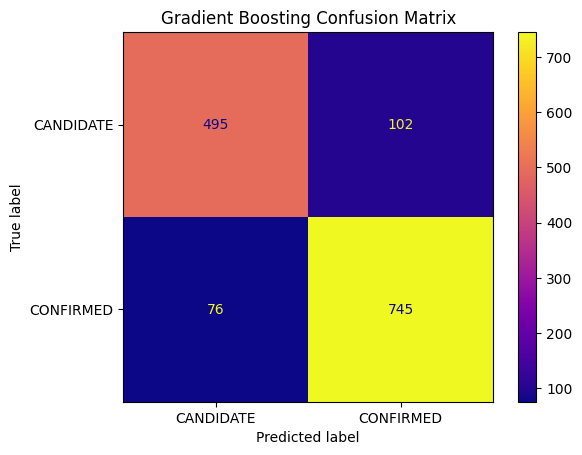

Classification Report:
               precision    recall  f1-score   support

   CANDIDATE       0.87      0.83      0.85       597
   CONFIRMED       0.88      0.91      0.89       821

    accuracy                           0.87      1418
   macro avg       0.87      0.87      0.87      1418
weighted avg       0.87      0.87      0.87      1418



In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Define and train the Gradient Boosting model
model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)

# 2. Predict on test data
y_pred = model.predict(X_test)

# 3. Get and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 4. Optional: Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='plasma')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# 5. Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))


NOW QML

In [13]:
pip install pennylane torch scikit-learn pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [14]:
import torch
from torch import nn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pennylane as qml
from pennylane import numpy as pnp

In [15]:
import pandas as pd
import numpy as np
from pennylane import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import time
start = time.time()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In [17]:
!pip install --upgrade qiskit qiskit-machine_learning qiskit-aer qiskit-ibm-runtime qiskit-algorithms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 13.1 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle

def preprocess_for_amplitude_embedding(df, target_feature_len=64):
    df = df.copy()

    # Drop unused columns
    df = df.drop(['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score'], axis=1)

    # Filter out 'FALSE POSITIVE' entries
    df = df[df['koi_disposition'].isin(['CANDIDATE', 'CONFIRMED'])].reset_index(drop=True)

    # Drop columns with all missing values
    df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

    # Fill missing values
    df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
    for column in df.columns[df.isna().sum() > 0]:
        df[column] = df[column].fillna(df[column].mean())

    # One-hot encode categorical
    df = pd.get_dummies(df, columns=['koi_tce_delivname'])

    # Encode labels
    label_encoder = LabelEncoder()
    df['koi_disposition'] = label_encoder.fit_transform(df['koi_disposition'])

    # Separate features and labels
    y = df['koi_disposition'].values
    X = df.drop('koi_disposition', axis=1).values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Pad feature vectors to match target length (next power of 2, e.g., 64)
    n_samples, n_features = X.shape
    if n_features > target_feature_len:
        X = X[:, :target_feature_len]
    elif n_features < target_feature_len:
        pad_width = target_feature_len - n_features
        X = np.pad(X, ((0, 0), (0, pad_width)), 'constant')

    # Normalize each vector to unit length (required for amplitude embedding)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X_normalized = X / norms

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, train_size=0.7, shuffle=True, random_state=1)

    return X_train, X_test, y_train, y_test


In [19]:
X_train, X_test, y_train, y_test = preprocess_for_amplitude_embedding(data, target_feature_len=64)


In [20]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn

n_qubits = 6  # Since 2^6 = 64
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=False)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

In [21]:
from pennylane.qnn import TorchLayer

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=False)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


# Weight shapes required
# Wrap into TorchLayer
weight_shapes = {"weights": (6, n_qubits, 3)}  # (layers, wires, params-per-wire)
qlayer = TorchLayer(qnode, weight_shapes)

# Define hybrid model
class HybridQMLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.quantum = qlayer
        self.fc = nn.Linear(n_qubits, 1)  # match quantum output

    def forward(self, x):
        x = self.quantum(x)
        x = self.fc(x)
        return torch.sigmoid(x)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=False)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]



In [22]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

model = HybridQMLModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# Training loop
n_epochs = 25
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss = {total_loss:.4f}")



Epoch 1: loss = 253.0809
Epoch 2: loss = 222.8587
Epoch 3: loss = 211.7391
Epoch 4: loss = 207.3928
Epoch 5: loss = 201.8438
Epoch 6: loss = 200.4127
Epoch 7: loss = 197.5709
Epoch 8: loss = 194.9159
Epoch 9: loss = 194.3834
Epoch 10: loss = 193.0675
Epoch 11: loss = 192.6335
Epoch 12: loss = 192.7805
Epoch 13: loss = 192.5062
Epoch 14: loss = 190.9510
Epoch 15: loss = 189.5754
Epoch 16: loss = 192.2410
Epoch 17: loss = 188.2246
Epoch 18: loss = 189.7148
Epoch 19: loss = 188.2363
Epoch 20: loss = 186.9948
Epoch 21: loss = 188.3812
Epoch 22: loss = 190.4559
Epoch 23: loss = 186.6695
Epoch 24: loss = 188.9413
Epoch 25: loss = 187.6093


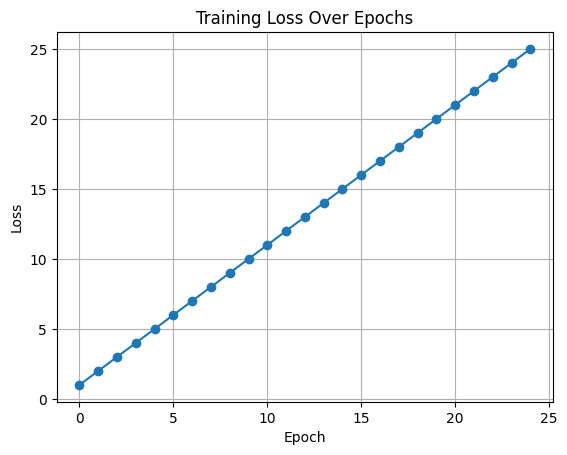

In [23]:
#Visual representation of epoch
import matplotlib.pyplot as plt
n_epochs=25
plt.plot(range(1, n_epochs + 1), marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [24]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    preds_binary = (preds > 0.5).float()
    acc = accuracy_score(y_test_tensor, preds_binary)
    print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.7884


In [25]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Ensure model is in eval mode
model.eval()

# Get predictions
with torch.no_grad():
    y_probs = model(X_test_tensor)  # shape: [num_samples, 1]
    y_pred = (y_probs > 0.5).float()

# Convert tensors to numpy arrays
y_true = y_test_tensor.numpy()
y_pred = y_pred.numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f"Accuracy  : {accuracy * 100:.2f}%")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")


Accuracy  : 78.84%
F1 Score  : 0.8305
Recall    : 0.8952
Precision : 0.7745


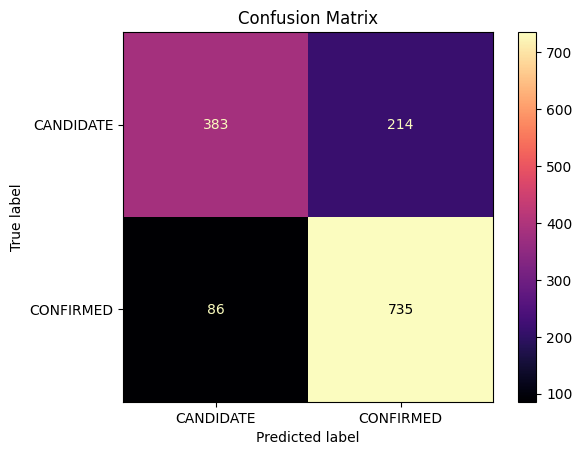

In [26]:
#visualization of correct vs. incorrect classifications
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CANDIDATE", "CONFIRMED"])
disp.plot(cmap='magma')
plt.title("Confusion Matrix")
plt.show()
